In [8]:
import scipy
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift, estimate_bandwidth

import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import beta
from math import sin
from random import randint

import matplotlib.pyplot as plt
import itertools as it

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
init_notebook_mode(connected=True)

import collections

def recursively_default_dict():
        return collections.defaultdict(recursively_default_dict)

from matplotlib.collections import BrokenBarHCollection
import re

from random import sample
from random import shuffle

import Lab_modules.Modules_tools


In [9]:
t= np.array([[0,1,1]])

t.shape

(1, 3)

In this post we will take what we did in **10. A link to Fsts** but allow our observations a degree of admixture.

We will do this by making use of an output of the software sNMF. 

Let's begin by construcing the vector universe from which we will extract the frequency vectors that will define our populations.

As in **10. A link to Fsts**, we will do this by generating a as many vectors as possible by sampling randomly from the beta distribution at varying values of that function's parameters, _a_ and _b_.

In [4]:

# We must first define the number of populations, the length of the haplotypes desired, and their respective population sizes
L= 300

import itertools as it
n= 20
n_samples= 20

a_range= np.linspace(1.5,2.5,n_samples)
a_set= [i for i in a_range for _ in range(n)]

b_range= np.linspace(0.1,.6,n_samples)
b_set= [i for i in b_range for _ in range(n)]

L_set= [L] * n * n_samples

traces= [x for x in it.product(range(n*11),range(n*11),range(n*11))]

background= np.array([a_set,b_set,L_set]).T

vector_lib= []
for k in range(background.shape[0]):
    
    probs= beta.rvs(background[k,0], background[k,1], size=int(background[k,2]))
    probs[(probs > 1)]= 1
    probs= [1-x for x in probs]
    
    
    vector_lib.append(probs)

vector_lib= np.array(vector_lib)



Because we will usive this _vector universe_ to inverse transform from new coordinates, and because operations conducted in this feature space are not limited by the number of dimensions, we will retain the first 50 pricipal components.

In [5]:
n_comp = 50

pca = PCA(n_components=n_comp, whiten=False,svd_solver='randomized')
features = pca.fit_transform(vector_lib)

var_comps= pca.explained_variance_ratio_
print("; ".join(['PC{0}: {1}'.format(x+1,round(var_comps[x],3)) for x in range(n_comp)]))
print('features shape: {}'.format(features.shape))

PC1: 0.045; PC2: 0.011; PC3: 0.011; PC4: 0.01; PC5: 0.01; PC6: 0.01; PC7: 0.01; PC8: 0.01; PC9: 0.01; PC10: 0.01; PC11: 0.009; PC12: 0.009; PC13: 0.009; PC14: 0.009; PC15: 0.009; PC16: 0.009; PC17: 0.009; PC18: 0.009; PC19: 0.009; PC20: 0.008; PC21: 0.008; PC22: 0.008; PC23: 0.008; PC24: 0.008; PC25: 0.008; PC26: 0.008; PC27: 0.008; PC28: 0.008; PC29: 0.008; PC30: 0.008; PC31: 0.007; PC32: 0.007; PC33: 0.007; PC34: 0.007; PC35: 0.007; PC36: 0.007; PC37: 0.007; PC38: 0.007; PC39: 0.007; PC40: 0.007; PC41: 0.007; PC42: 0.007; PC43: 0.007; PC44: 0.007; PC45: 0.007; PC46: 0.006; PC47: 0.006; PC48: 0.006; PC49: 0.006; PC50: 0.006
features shape: (400, 50)


In [6]:
#### Let's plot the first 3 coordinates nonetheless.
####
fig_data= [go.Scatter3d(
        x = features[:,0],
        y = features[:,1],
        z = features[:,2],
        type='scatter3d',
        mode= "markers",
        text= ['a: {}; b: {}, L: {}; index = {}'.format(background[k,0],background[k,1],background[k,2], k) for k in range(background.shape[0])],
        marker= {
        'line': {'width': 0},
        'size': 4,
        'symbol': 'circle',
      "opacity": .8
      }
    )]


layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    scene= Scene(
    yaxis=dict(
        title='PC2: {}'.format(round(var_comps[1],3))),
    xaxis=dict(
    title= 'PC1: {}'.format(round(var_comps[0],3))),
    zaxis=dict(
    title= 'PC3: {}'.format(round(var_comps[2],3))))
)

fig = go.Figure(data=fig_data, layout=layout)
iplot(fig)


The usefulness of this feature space is this:
    1. We can use to move frequency vectors around, by calculating new coordinates and inverse transforming them.
    2. Frequency vectors can be used to generate haplotypes, and Fsts, a measure of differentiation, is easily calculated from these vectors alone.

Let's choose three vectors, our sampling scheme.

In [5]:
#### calculating Fsts between populations.
Pops= [363,353,375]
Sizes= [80,100,30]

def return_fsts(vector_lib,pops):
    H= {pop: [1-(vector_lib[pop,x]**2 + (1 - vector_lib[pop,x])**2) for x in range(vector_lib.shape[1])] for pop in pops}
    Store= []
    for comb in it.combinations(pops,2):
        P= [sum([vector_lib[x,i] for x in comb]) / len(comb) for i in range(vector_lib.shape[1])]
        HT= [2 * P[x] * (1 - P[x]) for x in range(len(P))]
        Fst= np.mean([(HT[x] - np.mean([H[p][x] for p in comb])) / HT[x] for x in range(len(P))])
        
        Store.append([comb,Fst])
    
    ### total fst:
    P= [sum([vector_lib[x,i] for x in pops]) / len(pops) for i in range(vector_lib.shape[1])]
    HT= [2 * P[x] * (1 - P[x]) for x in range(len(P))]
    FST= np.mean([(HT[x] - np.mean([H[p][x] for p in pops])) / HT[x] for x in range(len(P))])
    
    return pd.DataFrame(Store,columns= ['pops','fst']),FST

Pairwise, Total_fst= return_fsts(vector_lib,Pops)

print('global fst: {}'.format(round(Total_fst,4)))
Pairwise

global fst: 0.1549


,pops,fst
0,"(363, 353)",0.095318
1,"(363, 375)",0.117140
2,"(353, 375)",0.106764


Now, about generating admixed haplotypes:

As before, we will conduct our simulations as two of our populations converge and diverge as a function of the sinusoid of a variable *X*, which we will make to vary between 0 and 30 at steps of .1.

At each variation of X, we generate haplotypes from our frequency vectors following the sampling scheme we defined above.

However, while before we followed this scheme in a strict fashion, extracting the same number of haplotypes from each vector at each step, now, we will treat each observation individually. At each step, a haplotype will be extracted from a population vector according to a probability we will define beforehand.

We will draw our probability vectors from the sNMF output of an anlysis where we had set K to 3. Like K-means, sNMF will draw the given number of clusters. It attributes to each individual analysed a probability towards each of the clusters it identifies.

In order to build somewhat consistent populations, we will class the observations in our sNMF analysis according to their maximum value. We will set a threshold, above which an accession will be classed into a group, and create an extra group, where we will store all observations whose maximum value falls bellow this threshold.

The trick here is that, if this threshold is above .5, each observation will forcibly fall into one group only. The higher we set it, the more skewed will be the probability vectors within each group - excepting the extra group of course. In population genetics terms, the higher this threshold the purer will be the accessions in each group.



As in the previous post, in each example explored here we will have two populations converge and diverge. The choice of which populations converge is of course left to the user. In this post i plot only the Truth ideograms, indicating from which frequency vector each haplotype is extracted along the crawl. These can be used to decide how we want to configure our population structure varions. i leave that to you.


In [7]:
### Reading the sNMF output, and classing according to an inclusion threshold.
def OriginbySNMF(Geno_Q,t):
    """
    Classes individuals according to Group assignment by SNMF
    using user provided threshold (.8 advised). returns dict.
    """
    Geneo = open(Geno_Q,"r")
    Ind = 0
    Inds= {}
    Groups = recursively_default_dict()
    for line in Geneo:
        line= line.split()
        line= [float(x.strip("\n")) for x in line]
        line= [x / sum(line) for x in line]
        if Ind == 0:
            Groups = {x:[] for x in range(len(line) + 1)}
        bagged = 0
        for value in range(len(line)):
            if line[value] >= t:
                Groups[value].append(line)
                bagged += 1
        if bagged == 0:
            Groups[len(line)].append(line)
        Ind += 1
        Inds[Ind]= line
    return Groups,Inds

inclusion_threshold= .7

Geno_Q = "Complementary_data/sNMF_out3K.Q"
Geneo, Ind_admx = OriginbySNMF(Geno_Q,inclusion_threshold)

In [8]:
#### let's create our populations
## we'll sample randomly from each of the set created from the admixture analysis.
Sizes= [120,70,100,50]

Origins= {x: sample(Geneo[x], Sizes[x]) for x in Geneo.keys()}

Origins= {x: {y:Origins[x][y] for y in range(len(Origins[x]))} for x in Origins.keys()}

#### we can store these in a way that will facilitate later requests:
Whose= []
ind_to_group= {}
label_vector= []
d= 0

for gp in Origins.keys():
    for acc in range(len(Origins[gp])):
        Whose.append(d)
        ind_to_group[d]= [gp,acc]
        label_vector.append(gp)
        d += 1


Simulations:
    
We have attributed each individual in our data set a probability vector, which we will use to determine, at each step, from which frequency vector its haplotype will be extracted.  We will call this probability vector transition_vector.

However, we don't necessarily wish our haplotypes to jump around all the time, which is what would happen to those haplotypes with even probability vectors (e.g. [.33,.33,.33]). In order to avoid this, we will establish a _Crossing Over probability_. 

This value (**COp** bellow), will be the probability that a given individual will have to _choose_ between populations at each step. At each step except the first, an accession first passes this test. If the value is positive, then its current population will be drawn from the transition vector, and its state updated.

The initial state will be determined from the transition vector directly. 

Let's proceed.

In [ ]:
labels= [0,1,2]
target= [1,2]
Chr= 1
color_ref= ['red','yellow','blue','black','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

COp= 5e-2

label_indicies= {x:[y for y in range(len(label_vector)) if label_vector[y] == x] for x in Origins.keys()}

Windows= recursively_default_dict()

haplotypes= {x:[] for x in Whose}
Out= {1:{}}
Ideo= []

target_indx= {z:[x for x in range(len(label_vector)) if label_vector[x] == z] for z in labels}
threshold= .005
P= 30

current= recursively_default_dict()

for angle in np.arange(1,10,.1):
    bl= int(angle*10000)
    end= bl+ 999
    Out[1][bl]= end
    coords= features[Pops,:]
    vector2= coords[target[1]] - coords[target[0]]
    
    coords[target[0]] = coords[target[0]] + [sin(angle) * x for x in vector2]
    
    new_freqs= pca.inverse_transform(coords)
    scramble= [x for x in range(new_freqs.shape[1])]
    shuffle(scramble)
    new_freqs[target[0]]= pca.inverse_transform(coords[target[0]])
    
    new_freqs= new_freqs[:,scramble]
    
    N_pops= len(Pops)
    
    data= []
    
    for acc in range(len(Whose)):
        Subject = 'sample' + str(acc)
        
        transition_p= Origins[ind_to_group[acc][0]][ind_to_group[acc][1]]
        
        if current[acc]:
            cross_over= np.random.choice([0,1], p=[1-COp,COp])
            if cross_over == 1:
                k= np.random.choice(labels, p=transition_p)
                current[acc]= k
            else:
                k= current[acc]
        else:
            k= np.random.choice(labels, p=transition_p)
            current[acc]= k
        
        probs= new_freqs[k,:]
        
        probs[(probs > 1)]= 1
        probs[(probs < 0)]= 0
        
        Haps= [np.random.choice([1,0],p= [1-probs[x],probs[x]]) for x in range(L)]
        
        Stock = ['Region_'+str(Chr)+ '_' + Subject,bl,end,color_ref[k]]
        Ideo.append(Stock)
        data.append(Haps)
    
    data= np.array(data)
    
    for hap in range(data.shape[0]):
        haplotypes[hap].extend(data[hap,:])
    
    pca2 = PCA(n_components=3, whiten=False,svd_solver='randomized')
    
    data= pca2.fit_transform(data)
    
    profiles= extract_profiles(data,target_indx)
    
    ### store stuff.
    Windows[bl]= profiles


Windows= {1:Windows}




adding ideograms...


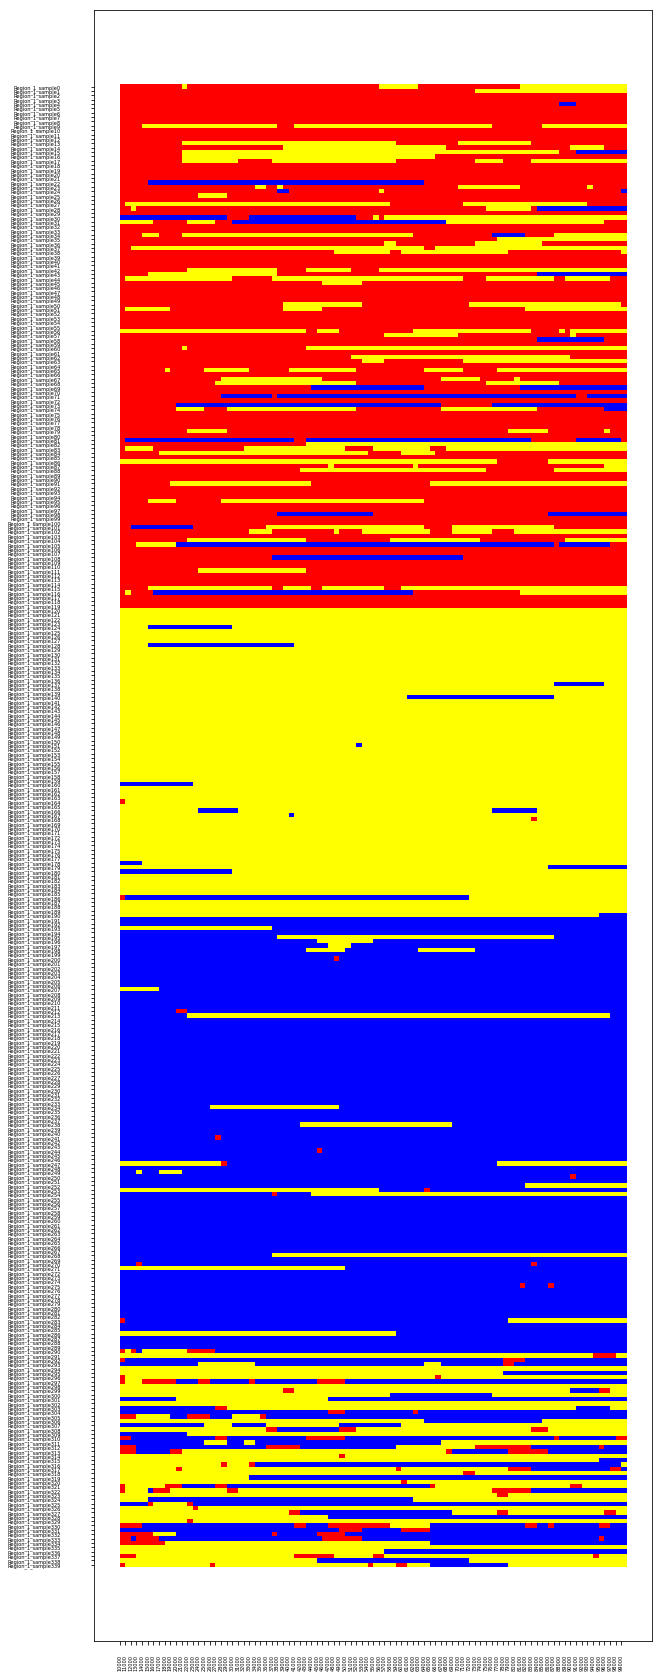

In [13]:

################
################        TRUTH

#### begin by compressing assignments by individuals. Lightens the load of the following plot.

import re
chromosome_list= []
chromosomes= [1]

for hap in Whose:
    Subject = 'sample' + str(hap)
    chromosome_list.extend(['Region_'+str(Chr)+ '_' + Subject for Chr in chromosomes])

ideo = pd.DataFrame(Ideo,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo = ideo[ideo.chrom.apply(lambda x: x in chromosome_list)]

ideo = compress_ideo(ideo,chromosome_list)

fig= return_ideogram(ideo)

Output of using sNMF derived admixture proportions to simulate admixed individuals in a structure setting we control.

Of course, you might be interested in a different scenario. For this you just have to play around with the composition of the sNMF derived transition_vectors. Or even create your own.

Let's try a two way admixture scenario with perfect reference populations:

In [16]:
# This block is the crucial part. The following steps will not be modified.

Sizes= [120,100,80]

Origins= {
    x:{
        y:[int(z == x) for z in range(len(Sizes) - 1)] for y in range(Sizes[x])
    } for x in range(len(Sizes) - 1)
}

import random

Admixed_proportions= [random.randrange(0,100) / float(100) for x in range(Sizes[-1])]

Origins[len(Sizes) - 1]= {
    y: [Admixed_proportions[y], 1 - Admixed_proportions[y]] for y in range(Sizes[-1])
}


#### we can store these in a way that will facilitate later requests:
Whose= []
ind_to_group= {}
label_vector= []
d= 0

for gp in Origins.keys():
    for acc in range(len(Origins[gp])):
        Whose.append(d)
        ind_to_group[d]= [gp,acc]
        label_vector.append(gp)
        d += 1



In [17]:


labels= [0,1]
target= [0,1]
Chr= 1
color_ref= ['red','yellow','blue','black','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

COp= 5e-2

label_indicies= {x:[y for y in range(len(label_vector)) if label_vector[y] == x] for x in Origins.keys()}

Windows= recursively_default_dict()

haplotypes= {x:[] for x in Whose}
Out= {1:{}}
Ideo= []
Blocks= {1:{}}
Fst_windows= []
Fst_crawl= []
Fst_labels= []

target_indx= {z:[x for x in range(len(label_vector)) if label_vector[x] == z] for z in labels}
threshold= .005
P= 30

current= recursively_default_dict()

for angle in np.arange(1,10,.1):
    bl= int(angle*10000)
    end= bl+ 999
    Out[1][bl]= end
    coords= features[Pops,:]
    vector2= coords[target[1]] - coords[target[0]]
    
    coords[target[0]] = coords[target[0]] + [sin(angle) * x for x in vector2]
    
    new_freqs= pca.inverse_transform(coords)
    scramble= [x for x in range(new_freqs.shape[1])]
    shuffle(scramble)
    new_freqs[target[0]]= pca.inverse_transform(coords[target[0]])
    
    new_freqs= new_freqs[:,scramble]
    
    N_pops= len(Pops)
    
    data= []
    local_labels= []
    
    for acc in range(len(Whose)):
        Subject = 'sample' + str(acc)
        
        transition_p= Origins[ind_to_group[acc][0]][ind_to_group[acc][1]]
        
        if current[acc]:
            cross_over= np.random.choice([0,1], p=[1-COp,COp])
            if cross_over == 1:
                k= np.random.choice(labels, p=transition_p)
                current[acc]= k
            else:
                k= current[acc]
        else:
            k= np.random.choice(labels, p=transition_p)
            current[acc]= k
        
        probs= new_freqs[k,:]
        
        probs[(probs > 1)]= 1
        probs[(probs < 0)]= 0
        
        Haps= [np.random.choice([1,0],p= [1-probs[x],probs[x]]) for x in range(L)]
        
        Stock = ['Region_'+str(Chr)+ '_' + Subject,bl,end,color_ref[k]]
        Ideo.append(Stock)
        data.append(Haps)
        local_labels.append(k + 1)
    
    data= np.array(data)
    
    for hap in range(data.shape[0]):
        haplotypes[hap].extend(data[hap,:])
    
    pca2 = PCA(n_components=3, whiten=False,svd_solver='randomized')
    
    data= pca2.fit_transform(data)
    
    profiles= extract_profiles(data,target_indx)
    
    ### get population fsts
#    Pairwise= return_fsts2(new_freqs)
#    Fst_labels.extend(Pairwise.pops)
    
#    Fst_crawl.extend(Pairwise.fst)
    
#    Fst_windows.extend([bl] * Pairwise.shape[0])
    ### store stuff.
    Blocks[1][bl]= local_labels
    Windows[bl]= profiles


Windows= {1:Windows}

adding ideograms...


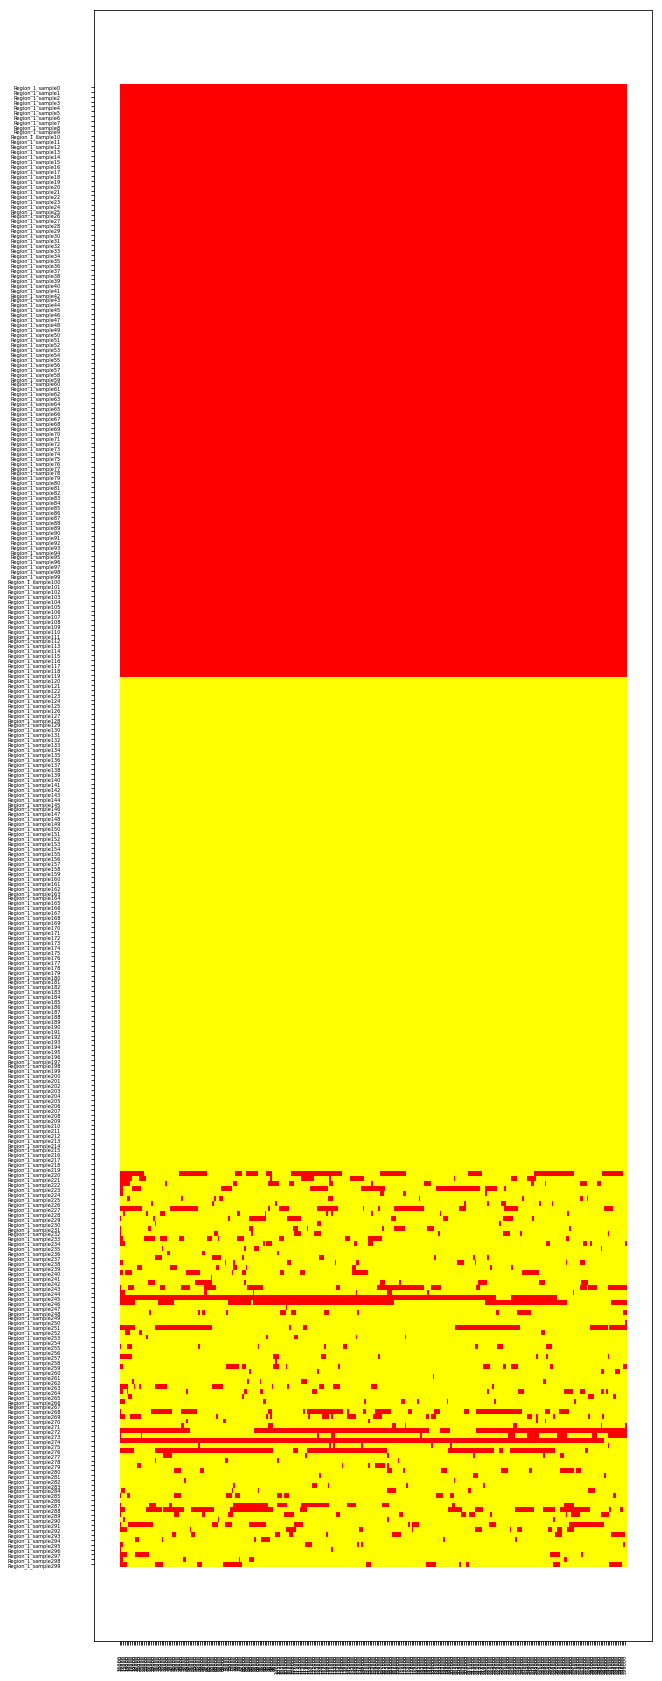

In [18]:
################
################        TRUTH

#### begin by compressing assignments by individuals. Lightens the load of the following plot.

import re
chromosome_list= []
chromosomes= [1]

for hap in Whose:
    Subject = 'sample' + str(hap)
    chromosome_list.extend(['Region_'+str(Chr)+ '_' + Subject for Chr in chromosomes])

ideo = pd.DataFrame(Ideo,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo = ideo[ideo.chrom.apply(lambda x: x in chromosome_list)]

ideo = compress_ideo(ideo,chromosome_list)

fig= return_ideogram(ideo)


**Two way admixture simulations using sNMF admixture proportions outputp**
